# Experiment 1

Hypothesis: Zeph will be able to see almost the same as complete discovery
(= full IPv4 routable prefixes) but with a much-reduced probing budget.

In [2]:
from pathlib import Path


exp_dir = Path("./resources/data/measurements/exp1/")

with (exp_dir / "zeph_10.txt").open("r") as fd:
    zeph_10_uuids = fd.readlines()
with (exp_dir / "zeph_25.txt").open("r") as fd:
    zeph_25_uuids = fd.readlines()
with (exp_dir / "zeph_50.txt").open("r") as fd:
    zeph_50_uuids = fd.readlines()
with (exp_dir / "zeph_75.txt").open("r") as fd:
    zeph_75_uuids = fd.readlines()
with (exp_dir / "zeph_10.txt").open("r") as fd:
    zeph_100_uuids = fd.readlines()

In [3]:
# Get Iris API / database credentials
from config.config import * 
from zeph.drivers import create_auth_header

headers = create_auth_header(iris_url, iris_username, iris_password)

## Links

In [4]:
from diamond_miner.queries import GetLinks
from zeph.drivers import get_previous_measurement_agents

def sanitize_uuid(uuid):
    return str(uuid).replace("-", "_")


def get_links(measurement_uuid):
    agents_uuid = get_previous_measurement_agents(iris_url, measurement_uuid, headers)
    
    distinct_links = set()
    for agent_uuid in agents_uuid:
        measurement_id = sanitize_uuid(measurement_uuid) + "__" + sanitize_uuid(agent_uuid)
        for link in GetLinks().execute_iter(database_url, measurement_id):
            distinct_links.add(link) 
    return distinct_links

In [5]:
zeph_10_n_links = []
for uuid in zeph_10_uuids:
    zeph_10_n_links.append(len(get_links(uuid.strip())))
zeph_25_n_links = []
for uuid in zeph_25_uuids:
    zeph_25_n_links.append(len(get_links(uuid.strip())))
zeph_50_n_links = []
for uuid in zeph_50_uuids:
    zeph_50_n_links.append(len(get_links(uuid.strip())))
zeph_75_n_links = []
for uuid in zeph_75_uuids:
    zeph_75_n_links.append(len(get_links(uuid.strip())))
zeph_100_n_links = []
for uuid in zeph_100_uuids:
    zeph_100_n_links.append(len(get_links(uuid.strip())))

print(zeph_10_n_links)
print(zeph_25_n_links)
print(zeph_50_n_links)
print(zeph_75_n_links)
print(zeph_100_n_links)

{"detail":"Measurement not found"}


KeyError: 'agents'

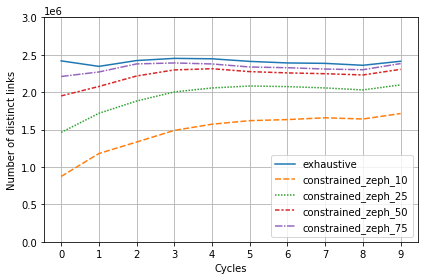

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "Zeph 10%": zeph_10_n_links,
    "Zeph 25%": zeph_25_n_links,
    "Zeph 50%": zeph_50_n_links,
    "Zeph 75%": zeph_75_n_links,
    "Zeph 100%": zeph_100_n_links,

})

ax = sns.lineplot(data=data)

ax.set(xlabel="Cycles", ylabel="Number of distinct links")
ax.set(ylim=(0, 3_000_000))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exp1_links.pdf")
plt.show()

## Nodes

In [ ]:
from diamond_miner.queries import GetNodes

def get_nodes(measurement_uuid):
    agents_uuid = get_previous_measurement_agents(iris_url, measurement_uuid, headers)
    
    distinct_nodes = set()
    for agent_uuid in agents_uuid:
        measurement_id = sanitize_uuid(measurement_uuid) + "__" + sanitize_uuid(agent_uuid)
        for node in GetNodes().execute_iter(database_url, measurement_id):
            distinct_nodes.add(node) 
    return distinct_nodes

In [ ]:
zeph_10_n_nodes = []
for uuid in zeph_10_uuids:
    zeph_10_n_nodes.append(len(get_nodes(uuid.strip())))
zeph_25_n_nodes = []
for uuid in zeph_25_uuids:
    zeph_25_n_nodes.append(len(get_nodes(uuid.strip())))
zeph_50_n_nodes = []
for uuid in zeph_50_uuids:
    zeph_50_n_nodes.append(len(get_nodes(uuid.strip())))
zeph_75_n_nodes = []
for uuid in zeph_75_uuids:
    zeph_75_n_nodes.append(len(get_nodes(uuid.strip())))
zeph_100_n_nodes = []
for uuid in zeph_100_uuids:
    zeph_100_n_nodes.append(len(get_nodes(uuid.strip())))

print(zeph_10_n_nodes)
print(zeph_25_n_nodes)
print(zeph_50_n_nodes)
print(zeph_75_n_nodes)
print(zeph_100_n_nodes)

[973613, 970403, 969690, 974730, 975849, 973826, 972308, 973173, 970543, 971206]
[]
[489027, 629993, 696452, 743172, 772598, 793157, 808389, 820351, 823607, 835815]
[739755, 839275, 877413, 903131, 916350, 920832, 919425, 919637, 914434, 921358]
[891826, 928864, 942693, 953281, 956170, 956573, 955400, 951645, 950642, 955361]
[948280, 956215, 963685, 966376, 966493, 963604, 964937, 964293, 961683, 965545]


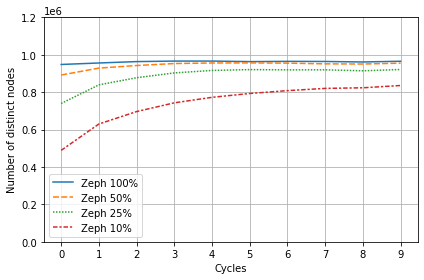

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "Zeph 10%": zeph_10_n_nodes,
    "Zeph 25%": zeph_25_n_nodes,
    "Zeph 50%": zeph_50_n_nodes,
    "Zeph 75%": zeph_75_n_nodes,
    "Zeph 100%": zeph_100_n_nodes,
})

ax = sns.lineplot(data=data)

ax.set(xlabel="Cycles", ylabel="Number of distinct nodes")
ax.set(ylim=(0, 1_200_000))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exp1_nodes.pdf")
plt.show()

## Probes 

In [ ]:
import requests 

def get_statistic(measurement_uuid, statistic):    
    data = requests.get(iris_url + f"/measurements/{measurement_uuid}", headers=headers)

    packets_sent = 0
    for agent in data.json()["agents"]:
        for probing_round in agent["probing_statistics"]:
            packets_sent += probing_round["statistics"].get(statistic, 0)
    return packets_sent

In [ ]:
zeph_10_n_probes = []
for uuid in zeph_10_uuids:
    zeph_10_n_probes.append(get_statistic(uuid.strip(), "packets_sent"))
zeph_25_n_probes = []
for uuid in zeph_25_uuids:
    zeph_25_n_probes.append(get_statistic(uuid.strip(), "packets_sent"))
zeph_50_n_probes = []
for uuid in zeph_50_uuids:
    zeph_50_n_probes.append(get_statistic(uuid.strip(), "packets_sent"))
zeph_75_n_probes = []
for uuid in zeph_75_uuids:
    zeph_75_n_probes.append(get_statistic(uuid.strip(), "packets_sent"))
zeph_100_n_probes = []
for uuid in zeph_100_uuids:
    zeph_100_n_probes.append(get_statistic(uuid.strip(), "packets_sent"))

print(zeph_10_n_probes)
print(zeph_25_n_probes)
print(zeph_50_n_probes)
print(zeph_75_n_probes)
print(zeph_100_n_probes)


[1485177000, 1485177000, 1485177000, 1485177000, 1485177000, 1485177000, 1485177000, 1485177000, 1485177000, 1485177000]
[148517625, 148517625, 148517625, 148517625, 148517625, 148517625, 148517625, 148517625, 148517625, 148517625]
[371294250, 371294250, 371294250, 371294250, 371294250, 371294250, 371294250, 371294250, 371294250, 371294250]
[742588500, 742588500, 742588500, 742588500, 742588500, 742588500, 742588500, 742588500, 742588500, 742588500]
[1113882750, 1113882750, 1113882750, 1113882750, 1113882750, 1113882750, 1113882750, 1113882750, 1113882750, 1113882750]


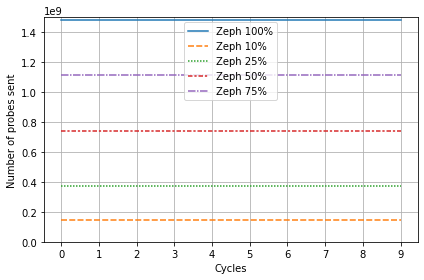

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "Zeph 10%": zeph_10_n_probes,
    "Zeph 25%": zeph_25_n_probes,
    "Zeph 50%": zeph_50_n_probes,
    "Zeph 75%": zeph_75_n_probes,
    "Zeph 100%": zeph_100_n_probes,
})

ax = sns.lineplot(data=data)

ax.set(xlabel="Cycles", ylabel="Number of probes sent")
ax.set(ylim=(0, 15_000_00_000))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exp1_probes.pdf")
plt.show()